In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import Adam

In [2]:
user_name = 'CY'  # 윈도우 사용자 이름으로 변경하세요
desktop_path = f'C:\\Users\\{user_name}\\Desktop'

In [3]:
# 이미지 경로 설정
train_asym_img_path = os.path.join(desktop_path, 'seg_train\\asym\\A2')
train_sym_img_path = os.path.join(desktop_path, 'seg_train\\sym\\A2')
validation_asym_img_path = os.path.join(desktop_path, 'seg_validation\\asym\\A2')
validation_sym_img_path = os.path.join(desktop_path, 'seg_validation\\sym\\A2')

In [4]:
# 마스크 이미지 경로 설정
train_asym_mask_path = os.path.join(desktop_path, 'seg_train\\asym\\A2_mask')
train_sym_mask_path = os.path.join(desktop_path, 'seg_train\\sym\\A2_mask')
validation_asym_mask_path = os.path.join(desktop_path, 'seg_validation\\asym\\A2_mask')
validation_sym_mask_path = os.path.join(desktop_path, 'seg_validation\\sym\\A2_mask')

In [5]:
# 이미지와 레이블을 저장할 리스트
images_list = []
masks_list = []
labels_list = []

In [6]:
# 무증상 이미지와 마스크 불러오기
for img_path, mask_path in zip([train_asym_img_path, validation_asym_img_path],
                               [train_asym_mask_path, validation_asym_mask_path]):
    if not os.path.exists(img_path) or not os.path.exists(mask_path):
        continue

    for img_name in os.listdir(img_path):
        if img_name.endswith('.jpg'):
            full_img_path = os.path.join(img_path, img_name)
            # 마스크 파일명 생성
            mask_name = img_name.replace('.jpg', '_mask.png')
            full_mask_path = os.path.join(mask_path, mask_name)

            img = cv2.imread(full_img_path)
            img = cv2.resize(img, (128, 128))
            mask = cv2.imread(full_mask_path, cv2.IMREAD_GRAYSCALE)

            if mask is None:
                print(f'Mask not found or error loading: {full_mask_path}')
                continue

            mask = cv2.resize(mask, (128, 128))

            images_list.append(img)
            masks_list.append(mask)
            labels_list.append(0)  # 무증상은 0으로 레이블링

In [7]:
# 유증상 이미지와 마스크 불러오기
for img_path, mask_path in zip([train_sym_img_path, validation_sym_img_path],
                               [train_sym_mask_path, validation_sym_mask_path]):
    if not os.path.exists(img_path) or not os.path.exists(mask_path):
        continue

    for img_name in os.listdir(img_path):
        if img_name.endswith('.jpg'):
            full_img_path = os.path.join(img_path, img_name)
            # 마스크 파일명 생성
            mask_name = img_name.replace('.jpg', '_mask.png')
            full_mask_path = os.path.join(mask_path, mask_name)

            img = cv2.imread(full_img_path)
            img = cv2.resize(img, (128, 128))
            mask = cv2.imread(full_mask_path, cv2.IMREAD_GRAYSCALE)

            if mask is None:
                print(f'Mask not found or error loading: {full_mask_path}')
                continue

            mask = cv2.resize(mask, (128, 128))

            images_list.append(img)
            masks_list.append(mask)
            labels_list.append(1)  # 유증상은 1으로 레이블링

In [8]:
# 불러온 이미지와 마스크의 개수를 출력하여 확인
print(f'Loaded images: {len(images_list)}')
print(f'Loaded masks: {len(masks_list)}')
print(f'Loaded labels: {len(labels_list)}')

Loaded images: 121140
Loaded masks: 121140
Loaded labels: 121140


In [9]:
batch_size = 10000
all_images = []
all_masks = []
all_labels = []
num_batches = len(images_list) // batch_size + 1

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(images_list))
    
    images_batch = np.array(images_list[start_idx:end_idx])
    masks_batch = np.array(masks_list[start_idx:end_idx])
    labels_batch = np.array(labels_list[start_idx:end_idx])
    
    # 각 배치의 데이터를 누적
    all_images.append(images_batch)
    all_masks.append(masks_batch)
    all_labels.append(labels_batch)

# 누적된 모든 배치를 하나의 배열로 합침
all_images = np.concatenate(all_images, axis=0)
all_masks = np.concatenate(all_masks, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [10]:
len(all_images)
len(all_masks)
len(all_labels)

121140

In [11]:
# 무증상과 유증상 이미지의 개수를 동일하게 맞추기 위해 오버샘플링
asym_indices = np.where(all_labels == 0)[0]
sym_indices = np.where(all_labels == 1)[0]

if len(asym_indices) < len(sym_indices):
    asym_indices = np.random.choice(asym_indices, len(sym_indices), replace=True)
else:
    sym_indices = np.random.choice(sym_indices, len(asym_indices), replace=True)

balanced_indices = np.concatenate([asym_indices, sym_indices])

images = all_images[balanced_indices]
masks = all_masks[balanced_indices]
labels = all_labels[balanced_indices]

In [12]:
# 데이터셋을 6:2:2 비율로 나누기 (train, validation, test)
X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

mask_temp, mask_test = train_test_split(masks, test_size=0.2, random_state=42, stratify=labels)
mask_train, mask_val = train_test_split(mask_temp, test_size=0.25, random_state=42, stratify=y_temp)

In [13]:
# 최적의 하이퍼파라미터를 반영한 CNN 모델 구성
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),  # conv_1_filter=32, conv_1_kernel=3
    MaxPooling2D((2, 2)),
    Conv2D(64, (5, 5), activation='relu'),  # conv_2_filter=64, conv_2_kernel=5
    MaxPooling2D((2, 2)),
    Conv2D(64, (5, 5), activation='relu'),  # conv_3_filter=64, conv_3_kernel=5
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),  # conv_4_filter=32, conv_4_kernel=3
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),  # dense_units=128
    Dropout(0.3),  # dropout=0.3
    Dense(1, activation='sigmoid')  # 이진 분류를 위해 출력 노드 수를 1로 설정하고, 활성화 함수를 sigmoid로 설정
])


C:\Users\CY\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# 검증 데이터셋을 사용하여 모델 평가 (학습 중간에 검증을 위해 사용됨)
validation_score = model.evaluate(X_val, y_val)
print(f'Validation accuracy: {validation_score[1]}')

# 테스트 데이터셋을 사용하여 최종 모델 평가
test_score = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_score[1]}')

Epoch 1/20
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 235s 102ms/step - accuracy: 0.5138 - loss: 0.7828 - val_accuracy: 0.5294 - val_loss: 0.6885
Epoch 2/20
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 250s 110ms/step - accuracy: 0.5274 - loss: 0.6883 - val_accuracy: 0.5182 - val_loss: 0.6910
Epoch 3/20
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 416s 183ms/step - accuracy: 0.5460 - loss: 0.6817 - val_accuracy: 0.6197 - val_loss: 0.6436
Epoch 4/20
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 417s 183ms/step - accuracy: 0.6287 - loss: 0.6414 - val_accuracy: 0.6610 - val_loss: 0.6135
Epoch 5/20
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 417s 184ms/step - accuracy: 0.6624 - loss: 0.6136 - val_accuracy: 0.6802 - val_loss: 0.5952
Epoch 6/20
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 416s 183ms/step - accuracy: 0.6790 - loss: 0.5970 - val_accuracy: 0.6869 - val_loss: 0.5823
Epoch 7/20
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 417s 183ms/step - accuracy: 0.6891 - loss: 0.5839 - val_accuracy: 0.6880 - val_loss: 0.5774
Epoch 8/20
2272/2272 ━━━━━━━━━━━━━━━━━━━━ 415s 183ms/step - ac

In [15]:
# 모델 저장
model.save('A2_cnn_model.keras')
print("Model saved as A2_model.keras")

Model saved as A2_model.keras


In [16]:
# 예측 함수
def predict_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    print(f'Probability of symptom: {prediction[0][0]*100:.2f}%')

# 예측 결과 확인
predict_image('C:\\Users\\CY\\Desktop\\seg_train\\sym\\A1_add\\IMG_D_A1_443683.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
Probability of symptom: 95.65%


In [17]:
predict_image('C:\\Users\\CY\\Desktop\\seg_train\\sym\\A1_add\\IMG_D_A1_443684.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Probability of symptom: 19.47%


In [18]:
predict_image('C:\\Users\\CY\\Desktop\\seg_train\\sym\\A1_add\\IMG_D_A1_443685.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Probability of symptom: 72.27%


### confusion matrix

In [19]:
# 모델 평가를 위해 테스트 세트에서 예측 수행
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # 0.5를 기준으로 이진 분류

758/758 ━━━━━━━━━━━━━━━━━━━━ 47s 62ms/step


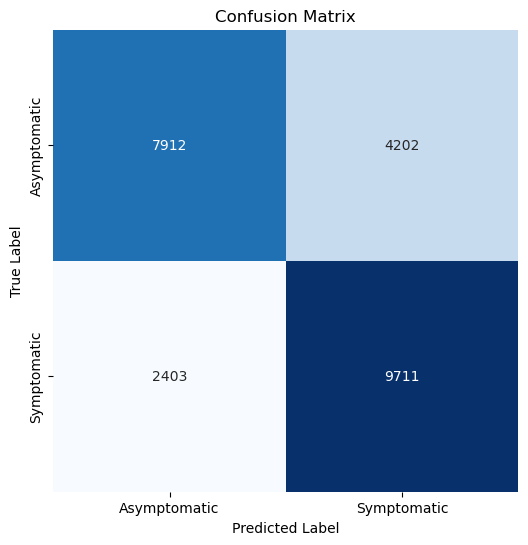

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix 시각화
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Asymptomatic', 'Symptomatic'], yticklabels=['Asymptomatic', 'Symptomatic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
# Classification Report 출력 (정밀도, 재현율, F1-Score 포함)
print('Classification Report')
print(classification_report(y_test, y_pred, target_names=['Asymptomatic', 'Symptomatic']))

Classification Report
              precision    recall  f1-score   support

Asymptomatic       0.77      0.65      0.71     12114
 Symptomatic       0.70      0.80      0.75     12114

    accuracy                           0.73     24228
   macro avg       0.73      0.73      0.73     24228
weighted avg       0.73      0.73      0.73     24228



AUC Score: 0.79162396790776


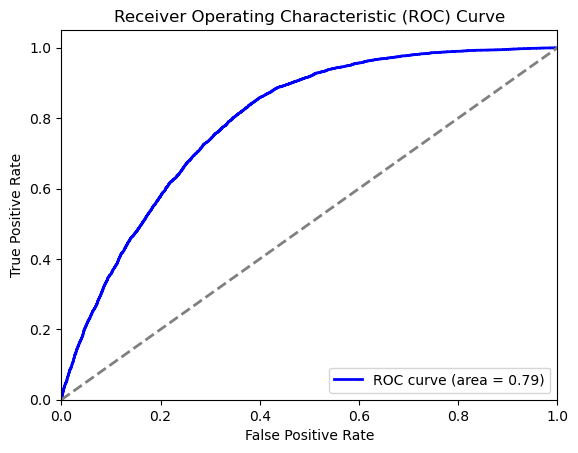

In [23]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
# ROC Curve 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

print(f'AUC Score: {auc}')

# ROC Curve 시각화
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# 그래프를 파일로 저장
plt.savefig('2_ROC Curve.png')
plt.show()

### 시각화

In [24]:
# 모델 학습 과정 시각화
def plot_training_history(history):
    # Epoch에 따른 Loss 시각화
    plt.figure(figsize=(14, 6))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss by Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy by Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

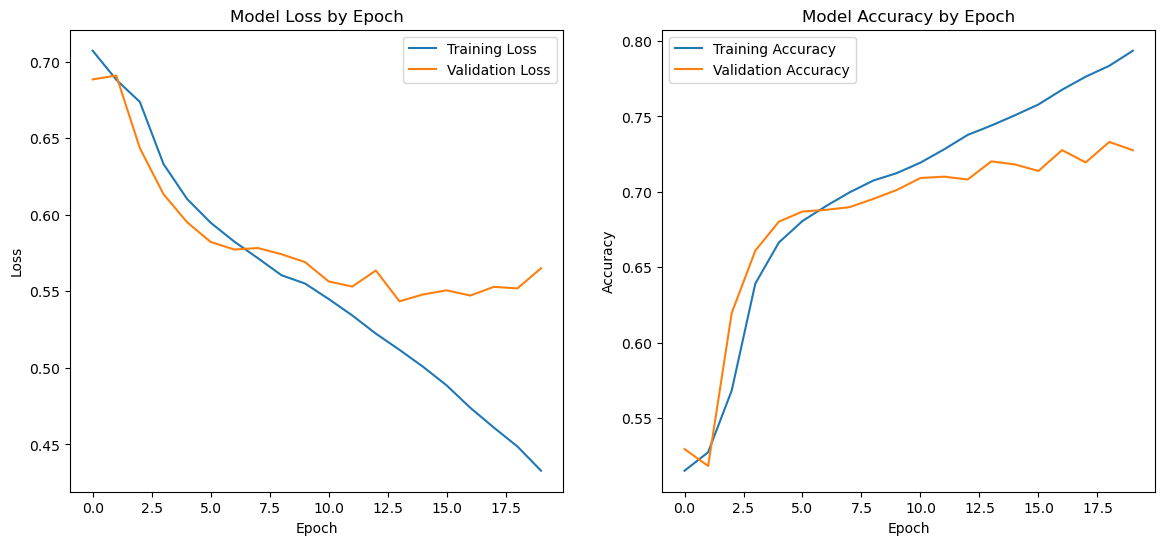

In [25]:
# 시각화 함수 호출
plot_training_history(history)